c:\Users\riko.lusa\src\phd-i4sec\.venv\Lib\site-packages\dgl\dataloading\dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(


{
  "accuracy": 0.9499427869249805,
  "macro": {
    "precision": 0.4882452172991768,
    "recall": 0.6087298587178906,
    "f1": 0.4503453386641302
  },
  "macro_FAR": 0.005075783380869556
}
False negatives by class: {'Analysis': 173, 'Backdoor': 144, 'Benign': 2403, 'DoS': 2286, 'Exploits': 15538, 'Fuzzers': 7879, 'Generic': 2685, 'Reconnaissance': 4059, 'Shellcode': 337, 'Worms': 18}


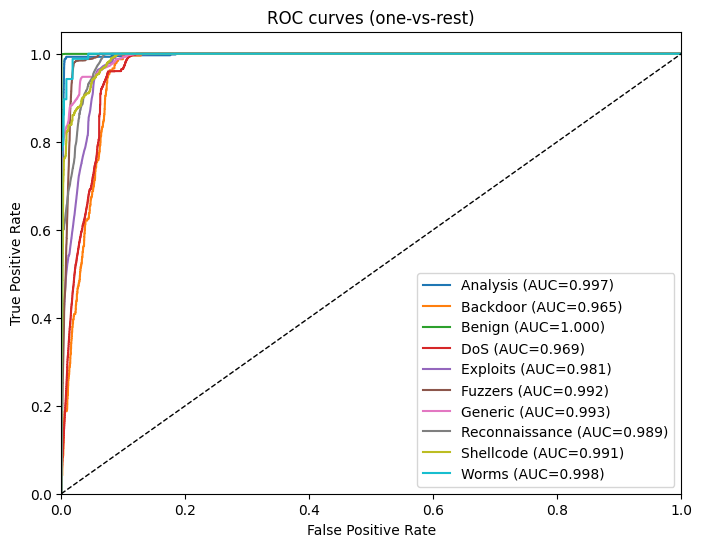

In [ ]:
import os, json, joblib, dgl, torch
import numpy as np
from feature_store import fetch_edge_features
from eval_utils import make_eval_loader
from eval_infer import infer_split
from eval_metrics import compute_metrics
from eval_roc import plot_roc_ovr, false_negatives_by_class

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load artifacts
g_val = dgl.load_graphs("graphs/val.bin")[0][0]
fs_val = "feature_store/val"

# label map
with open("artifacts/label_map.json","r",encoding="utf-8") as f:
    label2id = json.load(f)
id2label = {v:k for k,v in label2id.items()}
classes  = [id2label[i] for i in range(len(label2id))]

# Rebuild the model (must match your training config)
edge_in = fetch_edge_features(np.load(os.path.join(fs_val,"edge_indices.npy"))[:1], fs_val).shape[1]
hidden  = 128  # set to what you trained with
num_classes = len(label2id)

from train_edgecls_dbg import _FallbackEdgeGraphSAGE
model = _FallbackEdgeGraphSAGE(in_node=0, edge_in=edge_in, hidden=hidden, num_classes=num_classes, dropout=0.3).to(device)
model.load_state_dict(torch.load("artifacts/best_edge_sage.pt", map_location=device))
model.eval()

# Build loader for VAL
val_loader = make_eval_loader(g_val, fs_val, fanouts=(25,15), batch_size=2048)

# Inference
y_true, y_pred, y_prob = infer_split(model, val_loader, g_val, device, fetch_edge_features)

# Metrics
metrics = compute_metrics(y_true, y_pred, label2id)
# pull macro precision/recall (safe-get in case compute_metrics shape differs)
macro = metrics.get("macro", {})
macro_precision = macro.get("precision", None)
macro_recall = macro.get("recall", None)

print(json.dumps({
    "accuracy": metrics["accuracy"],
    "macro": metrics["macro"],
    "macro_FAR": metrics["macro_FAR"],
    "macro_precision": macro_precision,
    "macro_recall": macro_recall
}, indent=2))
# Confusion Matrix & FN
cm = np.array(metrics["confusion_matrix"])
fn_by_class = false_negatives_by_class(cm, classes)
print("False negatives by class:", fn_by_class)

# Save metrics
os.makedirs("artifacts", exist_ok=True)
with open("artifacts/metrics_val.json","w") as f:
    json.dump(metrics, f, indent=2)

# ROC curves
plot_roc_ovr(y_true, y_prob, classes, out_path="artifacts/roc_val.png")


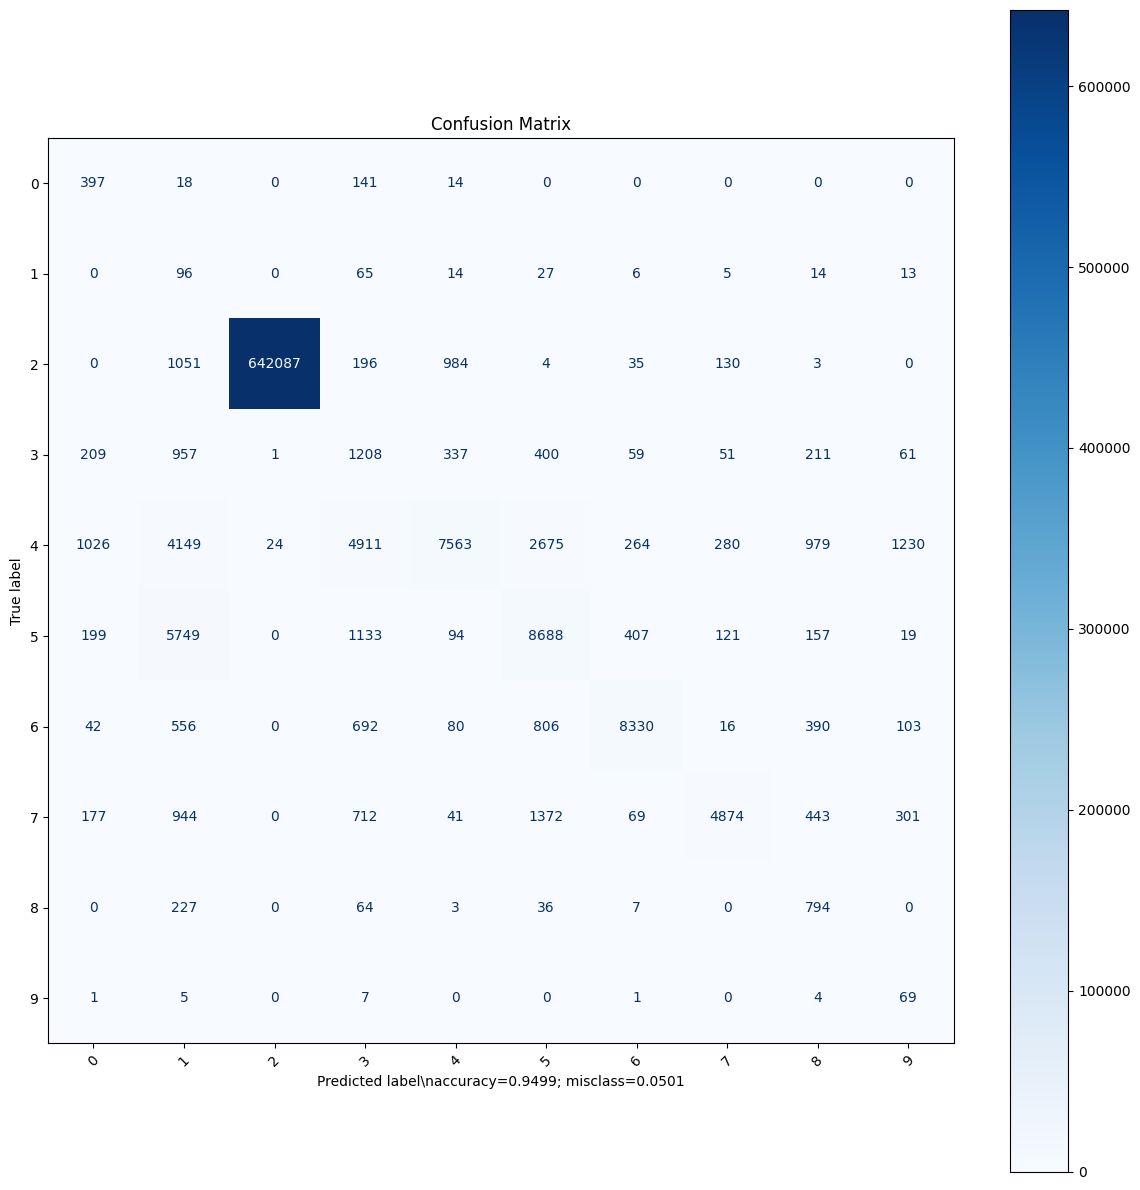

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# use inference outputs (y_true, y_pred) produced earlier in the notebook
cm = confusion_matrix(y_true, y_pred)
labels = np.unique(y_true)
accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy

fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap=mpl.colormaps['Blues'], colorbar=True)
plt.title("Confusion Matrix")
plt.xlabel(f'Predicted label\\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}')
plt.ylabel('True label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
from sklearn.metrics import confusion_matrix



False negatives per class:
  0: 173
  1: 144
  2: 2403
  3: 2286
  4: 15538
  5: 7879
  6: 2685
  7: 4059
  8: 337
  9: 18


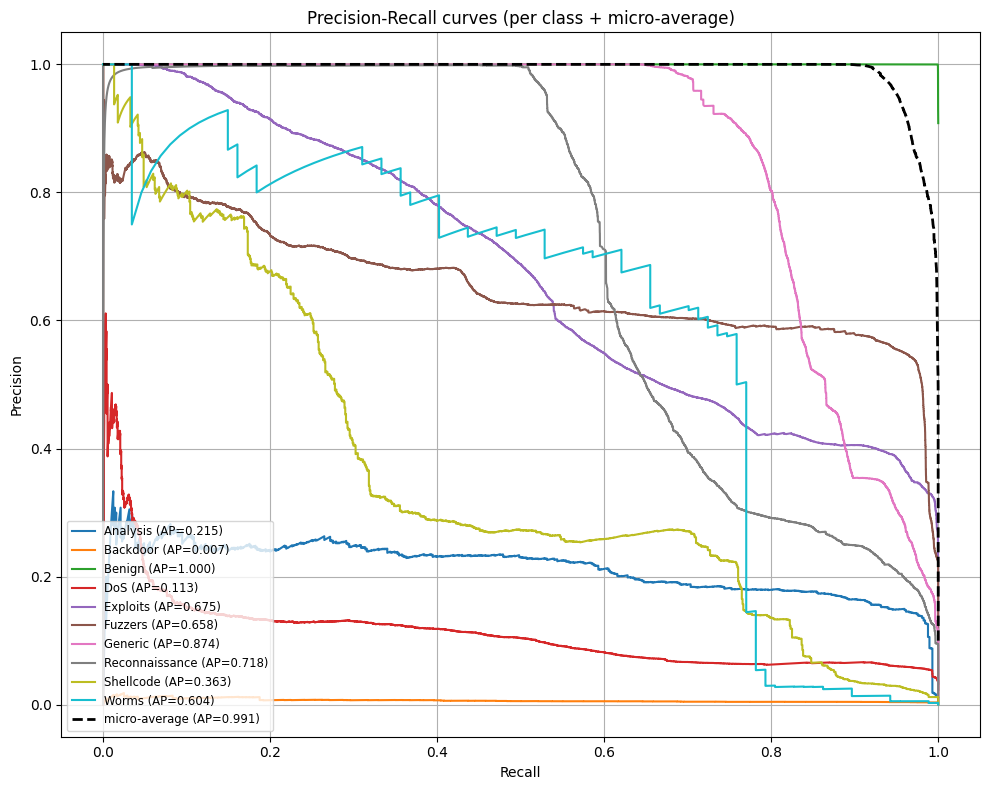

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import matplotlib as mpl

# Ensure y_prob is a NumPy array (infer_split returned logits)
if isinstance(y_prob, torch.Tensor):
    y_prob = y_prob.detach().cpu().numpy()

# Convert logits -> probabilities (binary or multiclass)
if y_prob.ndim == 1 or (y_prob.ndim == 2 and y_prob.shape[1] == 1):
    logits = y_prob.reshape(-1)
    probs_pos = 1.0 / (1.0 + np.exp(-logits))
    y_prob = np.vstack([1.0 - probs_pos, probs_pos]).T
else:
    logits = y_prob
    logits = logits - np.max(logits, axis=1, keepdims=True)
    exp = np.exp(logits)
    y_prob = exp / exp.sum(axis=1, keepdims=True)

# y_true (N,), y_prob (N, C) ready for PR plotting
num_classes = y_prob.shape[1]

# binarize true labels
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

# compute per-class PR and AP
plt.figure(figsize=(10, 8))
colors = mpl.colormaps['tab10']
for i in range(num_classes):
    prec, rec, _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_prob[:, i])
    plt.plot(rec, prec, label=f"{classes[i]} (AP={ap:0.3f})", color=colors(i % 10))

# micro-average
prec_micro, rec_micro, _ = precision_recall_curve(y_true_bin.ravel(), y_prob.ravel())
ap_micro = average_precision_score(y_true_bin, y_prob, average="micro")
plt.plot(rec_micro, prec_micro, label=f"micro-average (AP={ap_micro:0.3f})", color='black', linewidth=2, linestyle='--')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curves (per class + micro-average)")
plt.legend(loc="lower left", fontsize="small")
plt.grid(True)
plt.tight_layout()

os.makedirs("artifacts", exist_ok=True)
plt.savefig("artifacts/pr_curve_val.png", dpi=200)
plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(
    y_true,
    y_pred,
    labels,
    normalize=True,
    figsize=(8, 7),
    cmap="Blues",
    title=None,
    annotate=True,
    savepath=None,
):
    """
    Plot a confusion matrix heatmap.
    
    Parameters
    ----------
    y_true, y_pred : array-like, shape (n_samples,)
        Ground truth and predicted labels (as integer class IDs).
    labels : list[str]
        Class names in the same order as the integer IDs (0..K-1).
    normalize : bool
        If True, each row is normalized to sum to 1 (per-class recall proportions).
    figsize : tuple
        Figure size.
    title : str or None
        Title for the plot.
    annotate : bool
        If True, annotate each cell with the value.
    savepath : str or None
        If set, save figure to this path.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(labels)))
    if normalize:
        with np.errstate(all="ignore"):
            cm_display = cm.astype("float") / cm.sum(axis=1, keepdims=True)
            cm_display = np.nan_to_num(cm_display)
        fmt = ".2f"
        cbar_label = "Proportion"
        plot_title = title or "Confusion Matrix (Normalized by True Class)"
    else:
        cm_display = cm
        fmt = "d"
        cbar_label = "Count"
        plot_title = title or "Confusion Matrix"

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm_display, interpolation="nearest", cmap=cmap)
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(cbar_label, rotation=-90, va="bottom")

    ax.set(
        xticks=np.arange(len(labels)),
        yticks=np.arange(len(labels)),
        xticklabels=labels,
        yticklabels=labels,
        ylabel="True label",
        xlabel="Predicted label",
        title=plot_title,
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    if annotate:
        thresh = cm_display.max() / 2.0
        for i in range(cm_display.shape[0]):
            for j in range(cm_display.shape[1]):
                text_val = f"{cm_display[i, j]:{fmt}}"
                ax.text(
                    j, i, text_val,
                    ha="center", va="center",
                    color="white" if cm_display[i, j] > thresh else "black",
                    fontsize=10,
                )

    fig.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=150, bbox_inches="tight")
    plt.show()

    return cm  # return raw counts for further processing if needed


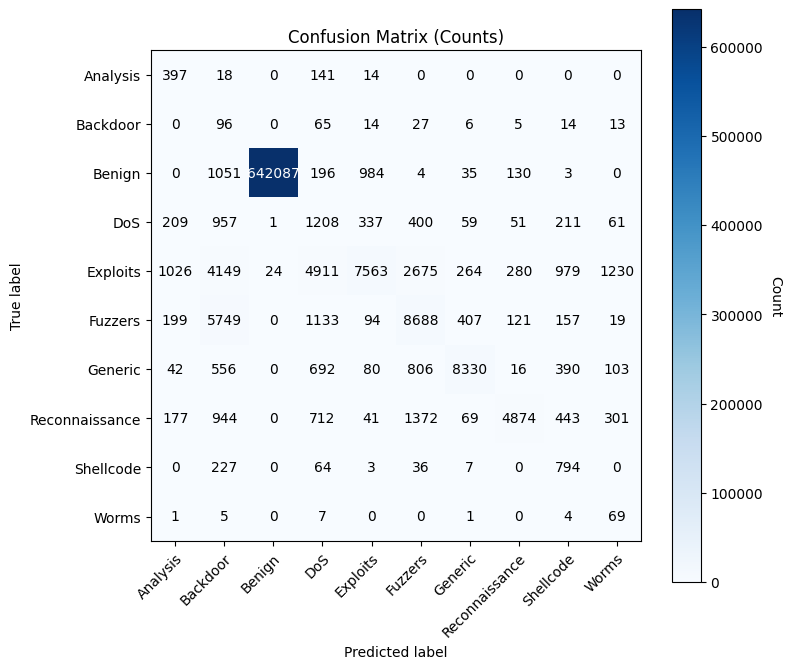

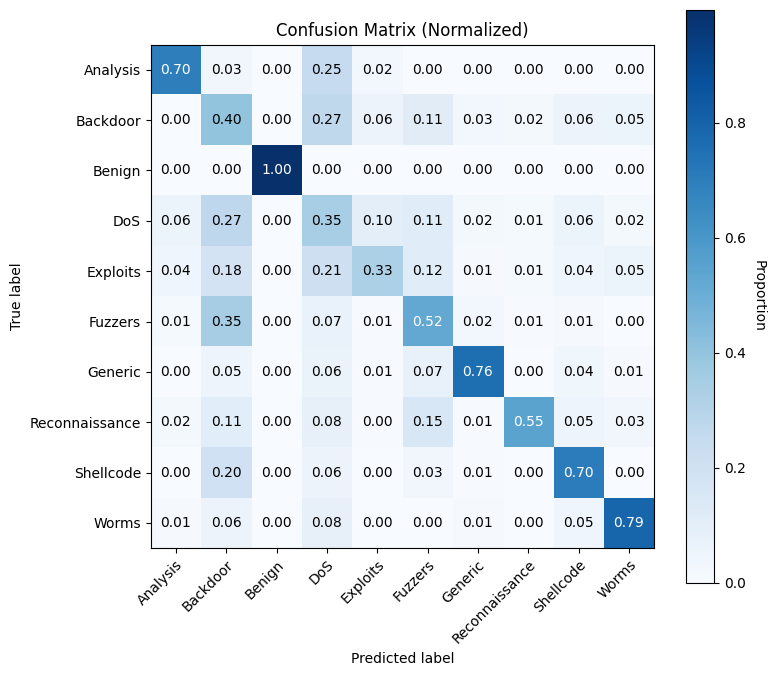

In [10]:
# labels must be list[str] in index order: [id0_name, id1_name, ...]
labels = [label2id_key for label2id_key in label2id.keys()]  # or build from id→label map
# Raw counts:
cm_counts = plot_confusion_matrix(y_true, y_pred, labels, normalize=False, title="Confusion Matrix (Counts)",
                                  savepath="artifacts/confusion_matrix_counts.png")
# Normalized (by true class / row):
cm_norm = plot_confusion_matrix(y_true, y_pred, labels, normalize=True, title="Confusion Matrix (Normalized)",
                                savepath="artifacts/confusion_matrix_normalized.png")


In [11]:
from sklearn.metrics import confusion_matrix

def per_class_errors(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(labels)))
    fn = cm.sum(axis=1) - np.diag(cm)  # false negatives per true class (missed)
    fp = cm.sum(axis=0) - np.diag(cm)  # false positives per predicted class
    return cm, fn, fp

cm, fn, fp = per_class_errors(y_true, y_pred, labels)
print("False negatives per class:")
for name, v in zip(labels, fn):
    print(f"  {name}: {int(v)}")


False negatives per class:
  Analysis: 173
  Backdoor: 144
  Benign: 2403
  DoS: 2286
  Exploits: 15538
  Fuzzers: 7879
  Generic: 2685
  Reconnaissance: 4059
  Shellcode: 337
  Worms: 18


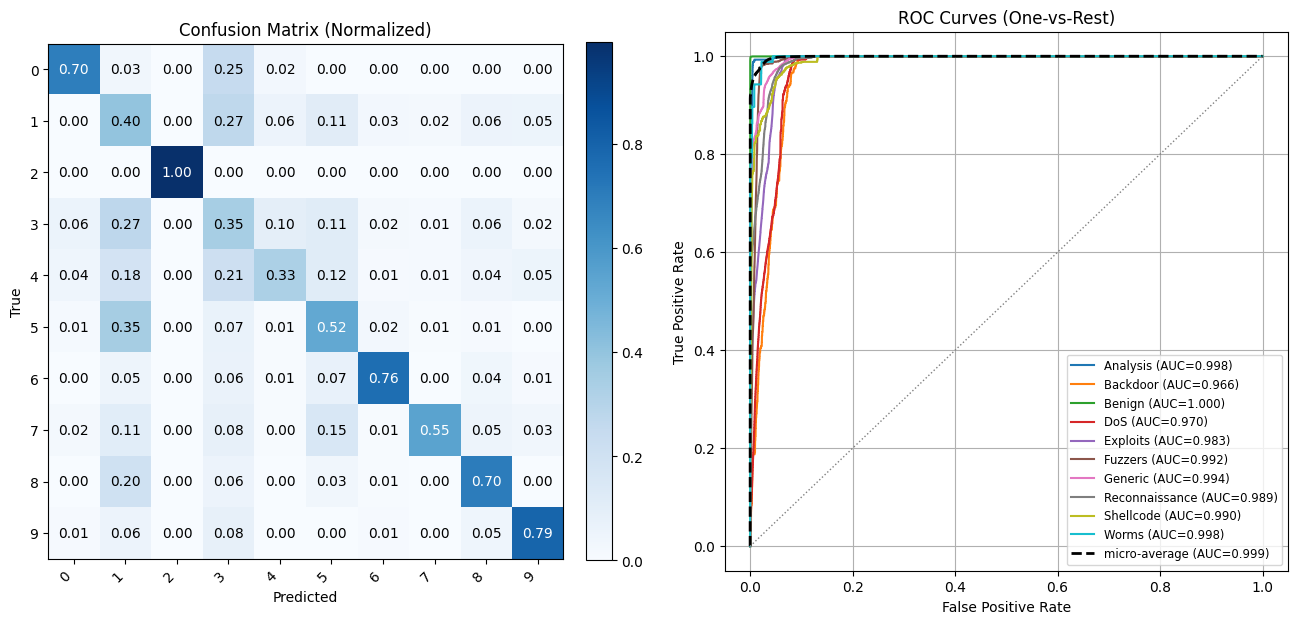

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: Confusion Matrix (Normalized)
cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(labels)))
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
im = axes[0].imshow(cm_norm, cmap="Blues")
axes[0].set_title("Confusion Matrix (Normalized)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")
axes[0].set_xticks(np.arange(len(labels))); axes[0].set_xticklabels(labels, rotation=45, ha="right")
axes[0].set_yticks(np.arange(len(labels))); axes[0].set_yticklabels(labels)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        axes[0].text(j, i, f"{cm_norm[i,j]:.2f}", ha="center", va="center",
                     color="white" if cm_norm[i,j] > 0.5 else "black")
fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

from sklearn.metrics import roc_curve, auc

n_classes = y_prob.shape[1]
y_true_bin_local = y_true_bin  # already computed in the notebook
axr = axes[1]
import matplotlib as mpl
cmap = mpl.colormaps['tab10']

fpr = {}
tpr = {}
roc_auc = {}

# per-class ROC
for i in range(n_classes):
    if np.sum(y_true_bin_local[:, i]) == 0:
        # no positive samples for this class in y_true -> skip plotting
        continue
    fpr[i], tpr[i], _ = roc_curve(y_true_bin_local[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    axr.plot(fpr[i], tpr[i], color=cmap(i % 10), lw=1.5, label=f"{classes[i]} (AUC={roc_auc[i]:0.3f})")

# micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin_local.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
axr.plot(fpr["micro"], tpr["micro"], color="black", lw=2, linestyle="--", label=f"micro-average (AUC={roc_auc['micro']:0.3f})")

# chance line and formatting
axr.plot([0, 1], [0, 1], color="grey", lw=1, linestyle=":")
axr.set_title("ROC Curves (One-vs-Rest)")
axr.set_xlabel("False Positive Rate")
axr.set_ylabel("True Positive Rate")
axr.legend(loc="lower right", fontsize="small")
axr.grid(True)

# save combined figure
os.makedirs("artifacts", exist_ok=True)
fig.savefig("artifacts/roc_vs_confusion.png", dpi=200, bbox_inches="tight")
